# MAKE DATA

In [2]:
import os
import random
import pickle
import json
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from huggingface_hub import HfApi, snapshot_download
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
# download raw data from kaggle
# !kaggle competitions download -c h-and-m-personalized-fashion-recommendations

In [ ]:
# !unzip ./data/raw/h-and-m-personalized-fashion-recommendations.zip -d ./data/raw/

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


seed = 42
seed_everything(42)

In [4]:
def dump_pickle(data, path):
    with open(path, "wb") as file:
        pickle.dump(data, file)


def load_pickle(path):
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data


def dump_json(data, path):
    with open(path, "w") as file:
        json.dump(data, file)


def load_json(path):
    with open(path, "r") as file:
        data = json.load(file)
    return data


def save_pt(data, path):
    with open(path, "wb") as file:
        torch.save(data, file)

In [5]:
def mk_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)


def get_timestamp(date_format: str = "%d%H%M%S") -> str:
    timestamp = datetime.now()
    return timestamp.strftime(date_format)


data_dir = "./data/20_core"
mk_dir(data_dir)

#### 데이터 load 및 shape 확인

In [4]:
item_data = pd.read_csv("./data/raw/articles.csv")
interaction_data = pd.read_csv("./data/raw/transactions_train.csv")

In [5]:
print(item_data.shape)
print(interaction_data.shape)

(105542, 25)
(31788324, 5)


In [6]:
is_equal = interaction_data.equals(
    interaction_data.sort_values(by=["t_dat", "customer_id"], axis=0).reset_index(
        drop=True
    )
)
print(f"날짜 및 사용자 기준으로 정렬된 것과 기존 데이터가 같은가? : {is_equal}")
# 정렬 필요하지 않음

날짜 및 사용자 기준으로 정렬된 것과 기존 데이터가 같은가? : True


In [7]:
# 다량 구매 하나로 줄이기(같은 아이템이 n개의 행에 연달아 나오는 경우 하나로 통합)
drop_idx = []

for idx in tqdm(range(1, len(interaction_data))):
    if interaction_data.iloc[idx - 1].equals(interaction_data.iloc[idx]):
        drop_idx.append(idx)

interaction_data = interaction_data.drop(index=drop_idx).reset_index(drop=True)

  0%|          | 0/31788323 [00:00<?, ?it/s]

In [10]:
print(item_data.shape)
print(interaction_data.shape)

(105542, 25)
(28839228, 5)


In [11]:
# 결측치 포함된 행 drop
n_item_data = item_data.dropna(axis=0, how="any").reset_index(drop=True)

In [ ]:
interaction_data.to_csv("./data/raw/no_dup_inter_data.csv", index=False)
n_item_data.to_csv("./data/raw/no_nan_item_data.csv", index=False)

In [13]:
print("shape of Item data : ", n_item_data.shape)
print("shape of interaction data : ", interaction_data.shape)

shape of Item data :  (105126, 25)
shape of interaction data :  (28839228, 5)


#### 이미지가 없는 아이템 찾기

In [14]:
def img_by_id(df, article_id: int, no_list: list, echo: int = 1, img_show: bool = True):
    if article_id in no_list:
        return
    if echo:
        display(df[df.article_id == article_id])

    img_id = "0" + str(article_id)
    img = Image.open("./data/raw/images/" + img_id[0:3] + "/" + img_id + ".jpg")

    if img_show:
        img.show()


def find_no_img_item(df):
    no_img = []

    for item in tqdm(df.iterrows(), total=len(df)):
        try:
            img_by_id(df, item[1][0], no_list=no_img, echo=0, img_show=False)
        except:
            no_img.append(item[0])

    return no_img

In [15]:
no_img_idx = find_no_img_item(n_item_data)

  0%|          | 0/105126 [00:00<?, ?it/s]

/tmp/ipykernel_2634939/4166981565.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_by_id(df, item[1][0], no_list=no_img, echo=0, img_show=False)


In [16]:
print("# of non-img item : ", len(no_img_idx))

# of non-img item :  430


In [18]:
# 이미지가 없는 아이템 삭제
# no_img_item = {idx:item_data.iloc[idx].article_id for idx in no_img_idx}
n_item_data = n_item_data.drop(index=no_img_idx, axis=0).reset_index(
    drop=True
)  # 이미지 없는 아이템을 삭제한 데이터
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (104696, 25)


In [ ]:
n_item_data.to_csv("./data/raw/no_img_item_data.csv", index=False)

#### 상품 카테고리(product_type_no)에 따른 필터링

In [21]:
# product_type에 속하는 상품이 10개 미만인 경우 삭제 131 -> 94로 줄어듦, 아이템은 약 130개 사라짐
n_item_data = (
    n_item_data.groupby("product_type_no")
    .filter(lambda x: len(x) >= 10)
    .reset_index(drop=True)
)
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (104569, 25)


In [23]:
# product_type 중 불필요한 것 삭제 -> 84로 줄어듧, 아이템 400개 정도 사라짐
rm_list = [
    "Umbrella",
    "Bracelet",
    "Giftbox",
    "Waterbottle",
    "Nipple covers",
    "Chem. cosmetics",
    "Fine cosmetics",
    "Soft Toys",
    "Bra extender",
    "Cushion",
    "Side table",
    "Dog Wear",
    "Keychain",
    "Sewing kit",
    "Towel",
    "Mobile case",
    "Zipper head",
    "Wireless earphone case",
    "Stain remover spray",
    "Clothing mist",
    "Hair ties",
]
n_item_data = n_item_data[~n_item_data["product_type_name"].isin(rm_list)].reset_index(
    drop=True
)
print("shape of n_item_data : ", n_item_data.shape)
print("# of product_type : ", n_item_data.product_type_name.nunique())

shape of n_item_data :  (104170, 25)
# of product_type :  84


In [29]:
# interacion data에서 앞선 과정에서 삭제된 데이터 제거
n_interaction_data = interaction_data[
    interaction_data["article_id"].isin(n_item_data["article_id"])
].reset_index(drop=True)
print("shape of interaction data : ", interaction_data.shape)
print("shape of n_interaction_data : ", n_interaction_data.shape)

shape of interaction data :  (28839228, 5)
shape of n_interaction_data :  (28518914, 5)


In [37]:
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (104170, 25)


In [36]:
n_item_data.to_csv("./data/raw/no_pord_type_item_data.csv", index=False)

In [31]:
n_interaction_data.to_csv("./data/raw/no_pord_type_inter_data.csv", index=False)

#### 구매이력

In [21]:
cnt_ = n_interaction_data.groupby(["customer_id"]).article_id.count()

In [22]:
pd.options.display.float_format = "{:.5f}".format

In [23]:
cnt_.describe()

count   1361131.00000
mean         21.02850
std          34.41201
min           1.00000
25%           3.00000
50%           9.00000
75%          24.00000
max        1636.00000
Name: article_id, dtype: float64

In [24]:
unique, counts = np.unique(cnt_, return_counts=True)

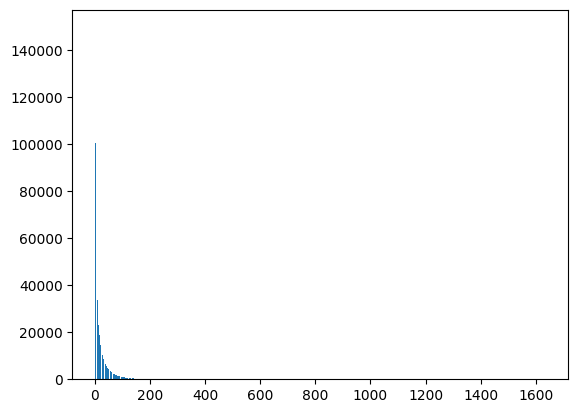

In [25]:
import matplotlib.pyplot as plt

# 구매 횟수에 대한 빈도 막대 그래프
plt.bar(unique, counts)
# plt.xlim((0,200))
# plt.ylim((0,500))
plt.show()

#### 아이템 및 유저의 상호작용 수에 따른 데이터 처리 (k-core data)

In [ ]:
n_interaction_data = pd.read_csv("./data/raw/no_pord_type_inter_data.csv")
print("shape of n_interaction_data : ", n_interaction_data.shape)

In [38]:
n_item_data = pd.read_csv("./data/raw/no_pord_type_item_data.csv")
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (104170, 25)


In [ ]:
# 아이템/유저 등장 빈도에 따른 데이터 구성
# 유저: 상호작용이 threshold 이하인 경우 삭제, 아이템 : 상호작용이 threshold 이하인 경우 삭제
# 상호작용 유저/아이템 수는 반복 구매를 제외하고 unique한 값을 기준으로 함
# 반복적으로 실행하여, 모든 유저, 아이템이 조건을 만족하도록 함


def data_cutter(origin_data, threshold=20):
    print("### before ###")
    print("shape of n_interaction_data : ", n_interaction_data.shape)
    while True:
        new_data = (
            origin_data.groupby("customer_id")
            .filter(lambda x: x.article_id.nunique() >= threshold)
            .reset_index(drop=True)
        )
        new_data = (
            new_data.groupby("article_id")
            .filter(lambda x: x.customer_id.nunique() >= threshold)
            .reset_index(drop=True)
        )

        if new_data.equals(origin_data):
            print("finish")
            break
        origin_data = new_data
        print("cut again")

    print("### after ###")
    print("shape of n_interaction_data : ", new_data.shape)
    print("num of user : ", new_data.customer_id.nunique())
    print("num of item : ", new_data.article_id.nunique())
    print(
        "data density : ",
        new_data.shape[0]
        / (new_data.customer_id.nunique() * new_data.article_id.nunique())
        * 100,
        "%",
    )

    return new_data

In [35]:
# n_interaction_data_10 = data_cutter(n_interaction_data, 10)
# n_interaction_data_20 = data_cutter(n_interaction_data, 20)
new_interaction_data = data_cutter(
    n_interaction_data, 20
)  # 아이템: 20미만 삭제, 유저: 20미만 삭제

### before ###
shape of n_interaction_data :  (28518914, 5)
cut again
cut again
cut again
cut again
cut again
finish
### after ###
shape of n_interaction_data :  (21910483, 5)
num of user :  392189
num of item :  65299
data density :  0.08555590948832915 %


In [ ]:
new_interaction_data.to_csv("./data/20_core/20_core_inter_data.csv", index=False)

In [40]:
n_item_data = n_item_data[
    n_item_data["article_id"].isin(new_interaction_data["article_id"])
].reset_index(drop=True)

In [ ]:
n_item_data.to_csv("./data/20_core/20_core_item_data.csv", index=False)
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (65299, 25)


In [44]:
print("shape of n_item_data : ", n_item_data.shape)
print("shape of new_interaction_data : ", new_interaction_data.shape)

shape of n_item_data :  (65299, 25)
shape of new_interaction_data :  (21910483, 5)


In [46]:
metadata = {
    "shape of interaction data": new_interaction_data.shape,
    "num of user": new_interaction_data.customer_id.nunique(),
    "num of item": new_interaction_data.article_id.nunique(),
    "data density": f"{new_interaction_data.shape[0]/(new_interaction_data.customer_id.nunique()*new_interaction_data.article_id.nunique())*100}%",
}
dump_json(metadata, f"{data_dir}/20_core_metadata.json")

#### 아이템 이미지 임베딩 생성 with fashion clip

In [6]:
new_interaction_data = pd.read_csv("./data/20_core/20_core_inter_data.csv")
n_item_data = pd.read_csv("./data/20_core/20_core_item_data.csv")

print("shape of n_item_data : ", n_item_data.shape)
print("shape of new_interaction_data : ", new_interaction_data.shape)

shape of n_item_data :  (65299, 25)
shape of new_interaction_data :  (21910483, 5)


In [9]:
from fashion_clip.fashion_clip import FashionCLIP

fclip = FashionCLIP("fashion-clip")

images = [
    "./data/raw/images/" + "0" + str(k)[0:2] + "/" + "0" + str(k) + ".jpg"
    for k in n_item_data["article_id"].tolist()
]
image_embeddings = fclip.encode_images(images, batch_size=1024)

  1%|          | 1/127 [05:13<10:59:15, 313.93s/it]
64it [23:12, 21.75s/it]                        


In [13]:
# {article_id : emb}
id_img_emb_map = {
    k: torch.tensor(v)
    for k, v in zip(n_item_data["article_id"].tolist(), image_embeddings)
}
torch.save(id_img_emb_map, f"{data_dir}/aritcle2img_emb.pt")

In [7]:
n_item_data["text"] = n_item_data.apply(lambda x:f"{x["prod_name"]} | {x['detail_desc']} | color : {x["colour_group_name"]} | appearance : {x['graphical_appearance_name']}", axis=1)

In [8]:
n_item_data["text"]

0        Strap top | Jersey top with narrow shoulder st...
1        Strap top | Jersey top with narrow shoulder st...
2        Strap top (1) | Jersey top with narrow shoulde...
3        OP T-shirt (Idro) | Microfibre T-shirt bra wit...
4        OP T-shirt (Idro) | Microfibre T-shirt bra wit...
                               ...                        
65294    Saturday jogger | Joggers in sweatshirt fabric...
65295    Virgo sweater fast buy | Short, boxy-style top...
65296    Virgo sweater fast buy | Short, boxy-style top...
65297    Heavy plain overknee tights 1p | Fine-knit tig...
65298    SPORT Malaga tank | Loose-fitting sports vest ...
Name: text, Length: 65299, dtype: object

In [9]:
from fashion_clip.fashion_clip import FashionCLIP

fclip = FashionCLIP("fashion-clip")

texts = n_item_data["text"].tolist()
text_embeddings = fclip.encode_text(texts, batch_size=64)

Map:   0%|          | 0/65299 [00:00<?, ? examples/s]

1021it [00:40, 25.19it/s]                          


In [13]:
# {article_id : emb}
id_text_emb_map = {
    k: torch.tensor(v)
    for k, v in zip(n_item_data["article_id"].tolist(), text_embeddings)
}
torch.save(id_text_emb_map, f"{data_dir}/aritcle2text_emb.pt")

#### id mapping

In [11]:
user2idx = {
    v: k for k, v in enumerate(new_interaction_data["customer_id"].unique())
}  # {user_id:idx}
item2idx = {
    v: k for k, v in enumerate(n_item_data["article_id"].unique())
}  # {item_id:idx}

print("# of user", len(user2idx))
print("# of item", len(item2idx))

# torch.save(item2idx, f"{data_dir}/item2idx.pt")

# of user 392189
# of item 65299


In [15]:
item_idx_img_emb = {v: id_img_emb_map[k] for k, v in item2idx.items()}
torch.save(item_idx_img_emb, f"{data_dir}/idx2img_emb.pt")

In [18]:
item_idx_text_emb = {v: id_text_emb_map[k] for k, v in item2idx.items()}
torch.save(item_idx_text_emb, f"{data_dir}/idx2text_emb.pt")

In [19]:
item_attr = {}

for _, row in tqdm(n_item_data.iterrows()):
    item_attr[int(row["article_id"])] = {
        "title": row["prod_name"],
        "type": row["product_type_name"],
        "graphic": row["graphical_appearance_name"],
        "color": row["colour_group_name"],
        "desc": row["detail_desc"],
    }

0it [00:00, ?it/s]

In [7]:
n_item_data

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65294,949198001,949198,Saturday jogger,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Joggers in sweatshirt fabric made from a cotto...
65295,949551001,949551,Virgo sweater fast buy,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy,"Short, boxy-style top in sweatshirt fabric mad..."
65296,949551002,949551,Virgo sweater fast buy,252,Sweater,Garment Upper body,1010016,Solid,52,Pink,...,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy,"Short, boxy-style top in sweatshirt fabric mad..."
65297,952267001,952267,Heavy plain overknee tights 1p,304,Underwear Tights,Socks & Tights,1010013,Other pattern,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit tights with an elasticated waist tha...


In [12]:
max_len = 20
n_item_data.loc[:, "prod_name"] = n_item_data["prod_name"].apply(
    lambda x: " ".join(str(x).split()[:max_len])
)
n_item_data.loc[:, "graphical_appearance_name"] = n_item_data[
    "graphical_appearance_name"
].apply(lambda x: " ".join(str(x).split()[:max_len]))
n_item_data.loc[:, "perceived_colour_value_name"] = n_item_data[
    "perceived_colour_value_name"
].apply(lambda x: " ".join(str(x).split()[:max_len]))
n_item_data.loc[:, "section_name"] = n_item_data["section_name"].apply(
    lambda x: " ".join(str(x).split()[:max_len])
)
n_item_data.loc[:, "detail_desc"] = n_item_data["detail_desc"].apply(
    lambda x: " ".join(str(x).split()[:max_len])
)
n_item_data.loc[:, "meta"] = n_item_data.apply(
    lambda x: f'Name {x["prod_name"]} Appearance {x["graphical_appearance_name"]} Color {x["perceived_colour_value_name"]} Section {x["section_name"]}',
    axis=1,
)

In [14]:
n_item_data["meta"][0]

'Name Strap top Appearance Solid Color Dark Section Womens Everyday Basics'

In [16]:
article2meta = {row[0]: row["meta"] for _, row in n_item_data.iterrows()}

/tmp/ipykernel_2737750/2801699320.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  article2meta = {row[0]:row["meta"] for _ , row in n_item_data.iterrows()}


In [18]:
torch.save(article2meta, f"{data_dir}/article2meta.pt")

In [ ]:
torch.save(item_attr, f"{data_dir}/article2attr.pt")

In [24]:
n_item_data = n_item_data[["article_id"]]
new_interaction_data = new_interaction_data[["customer_id", "article_id"]]

In [25]:
new_interaction_data["customer_id"] = new_interaction_data["customer_id"].map(user2idx)
new_interaction_data["article_id"] = new_interaction_data["article_id"].map(item2idx)
n_item_data["article_id"] = n_item_data["article_id"].map(item2idx)

In [27]:
n_item_data.head()

,article_id
0,0
1,1
2,2
3,3
4,4


In [28]:
new_interaction_data.head()

,customer_id,article_id
0,0,3325
1,0,25074
2,0,25075
3,0,25072
4,0,3324


#### train/valid/test split

In [65]:
# new_interaction_data = new_interaction_data.drop(["t_dat", "price","sales_channel_id"], axis=1)
unique_data = new_interaction_data.drop_duplicates(
    ["article_id", "customer_id"], keep="last"
)

In [66]:
new_interaction_data.shape

(21910483, 2)

In [67]:
unique_data.shape

(20641383, 2)

split by time

In [68]:
tqdm.pandas()
test_data = dict(unique_data.groupby("customer_id")["article_id"].progress_apply(list))

  0%|          | 0/392189 [00:00<?, ?it/s]

IOStream.flush timed out


In [69]:
unique_data[unique_data["customer_id"] == 0].head(25)

,customer_id,article_id
0,0,3325
1,0,25074
2,0,25075
3,0,25072
4,0,3324
72372,0,3464
72373,0,4159
72374,0,10914
189954,0,4383
189955,0,812


In [70]:
test_data

{0: [3325,
  25074,
  25075,
  25072,
  3324,
  3464,
  4159,
  10914,
  4383,
  812,
  9758,
  9759,
  7904,
  8611,
  5717,
  15275,
  8945,
  7354,
  13357,
  7353,
  2153,
  5536,
  9128,
  1486,
  21168,
  21167,
  19221,
  848,
  2401,
  15648,
  34594,
  24045,
  29924,
  11436,
  24338,
  17314,
  23249,
  23248,
  6791,
  24230,
  11438,
  14660,
  17366,
  1741,
  23295,
  14498,
  15649,
  26868,
  15948,
  17313,
  20744,
  16383,
  14515,
  1567,
  22304,
  29876,
  7237,
  10964,
  22034,
  27274,
  11538,
  19455,
  20620,
  14518,
  26705,
  19081,
  26706,
  19909,
  20796,
  30865,
  21107,
  24030,
  8042,
  40541,
  18373,
  8654,
  39037,
  4458,
  12779,
  12777,
  32032,
  45475,
  30891,
  33525,
  5991,
  19883,
  46065,
  3809,
  12780,
  46524,
  609,
  35439,
  46988,
  611,
  12010,
  39022,
  21278,
  820,
  33960,
  64,
  56854,
  983,
  63,
  557,
  5980,
  50734],
 1: [25903,
  3107,
  10514,
  25910,
  25902,
  7505,
  10548,
  25474,
  6477,
  17112,


In [86]:
torch.save(test_data, "./data/20_core/uniqued_test_data.pt")

In [104]:
sample_size = 30000
xs_idx = np.random.choice(len(user2idx), size=sample_size, replace=False)
print(min(xs_idx), max(xs_idx))
xs_idx[:50]

24 392174


array([ 33315, 295653, 283629, 215965,  98571, 135867,  12562, 375462,
       375153,  30372,  39393,  40384, 133577,  42501, 126448, 364429,
       197635, 185132, 152491,  91526, 289879,  39054,  83279, 306577,
       295733, 371642, 155095,   2251, 264663, 191479, 216710, 305477,
       382114, 283831, 319951,  41391,  14168, 138567, 332936, 180035,
       315688, 277172, 356470,  60827, 186929,  20765,  11082, 173406,
        36251,  58805])

In [105]:
test_data_xs = [test_data[i] for i in xs_idx]

In [106]:
test_data_xs[0]

[863,
 9759,
 9138,
 862,
 10801,
 10802,
 14199,
 32089,
 2309,
 15279,
 5731,
 3992,
 1803,
 57754,
 53337,
 61141,
 57577,
 568,
 57579,
 28182,
 61057,
 47861,
 812,
 9277,
 9284,
 52163,
 55588,
 40242,
 58911,
 54188,
 62703,
 60483,
 42553,
 60482,
 59727,
 59726]

In [107]:
torch.save(test_data_xs, "./data/20_core/uniqued_test_data_xs.pt")

In [ ]:
test_data = unique_data.groupby("customer_id").nth(-1)
valid_data = unique_data.groupby("customer_id").nth(-2)

print(
    f"test 및 valid가 중복없이 생성되었는가? : {pd.concat([valid_data, test_data]).drop_duplicates(keep=False).shape[0] == (valid_data.shape[0] + test_data.shape[0])}"
)

test 및 valid가 중복없이 생성되었는가? : True


split by time (unused item case)

In [49]:
test_data = (
    unique_data.groupby("customer_id").nth(-1).reset_index()
)  # 가장 마지막 1개 추출
user_item_dict = dict(list(new_interaction_data.groupby("customer_id")))

for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    i = -1
    item = row.article_id
    user = row.customer_id

    while (
        sum(user_item_dict[user].article_id.isin([item])) > 1
    ):  # 구매 이력에 1번 이상 존재하는 경우 그 앞의 것 확인
        i -= 1
        item = user_item_dict[user].article_id.iloc[i]
        # print(f"{idx, user} Again")

    test_data.at[idx, "article_id"] = item

  0%|          | 0/190977 [00:00<?, ?it/s]

In [50]:
# 값이 변경됐는지 확인
print(test_data.iloc[50])
print(unique_data.groupby("customer_id").nth(-1).reset_index().iloc[50])

index          2325131
customer_id     162082
article_id        3174
Name: 50, dtype: int64
index          2325131
customer_id     162082
article_id        3174
Name: 50, dtype: int64


In [51]:
unique_data = unique_data[
    ~unique_data.index.isin(test_data["index"])
]  # test set으로 추출된 것 제거

In [52]:
valid_data = (
    unique_data.groupby("customer_id").nth(-1).reset_index()
)  # 가장 마지막 1개 추출 -> test를 제외하였으므로 -2번째로 볼 수 있음

for idx, row in tqdm(valid_data.iterrows(), total=len(valid_data)):
    i = -1
    item = row.article_id
    user = row.customer_id

    while (
        sum(user_item_dict[user].article_id.isin([item])) > 1
    ):  # 구매 이력에 1번 이상 존재하는 경우 제외
        i -= 1
        item = user_item_dict[user].article_id.iloc[i]
        # print(f"{idx, user} Again")

    valid_data.at[idx, "article_id"] = item

  0%|          | 0/190977 [00:00<?, ?it/s]

In [53]:
# 값이 변경됐는지 확인
print(valid_data.iloc[199])
print(unique_data.groupby("customer_id").nth(-2).reset_index().iloc[199])

index          3661442
customer_id     151871
article_id       25328
Name: 199, dtype: int64
index          3498184
customer_id     117085
article_id       31396
Name: 199, dtype: int64


In [54]:
print(
    f"test 및 valid가 중복없이 생성되었는가? : {pd.concat([valid_data, test_data]).drop_duplicates(keep=False).shape[0] == (valid_data.shape[0] + test_data.shape[0])}"
)

test 및 valid가 중복없이 생성되었는가? : True


test/valid로 선정된 것 train에서 제거

In [55]:
drop_index = pd.Index([None])

for key, data in tqdm(
    new_interaction_data.groupby("customer_id"),
    total=new_interaction_data.customer_id.nunique(),
):
    valid_item = valid_data[valid_data.customer_id == key].article_id
    test_item = test_data[test_data.customer_id == key].article_id
    idxs = data[data.article_id.isin(np.concatenate((valid_item, test_item)))].index
    if len(idxs) > 2:  # 검증용
        print(key)
    drop_index = drop_index.append(idxs)

  0%|          | 0/190977 [00:00<?, ?it/s]

In [56]:
drop_index = drop_index.dropna()  # remove None
train_data = new_interaction_data.drop(index=drop_index)

test_data = test_data.reset_index(drop=True).drop(columns="index")
valid_data = valid_data.reset_index(drop=True).drop(columns="index")
train_data = train_data.reset_index(drop=True)

valid_data = valid_data.sort_values(by="customer_id").reset_index(drop=True)
test_data = test_data.sort_values(by="customer_id").reset_index(drop=True)

print("shape of test_data : ", test_data.shape)
print("shape of valid_data : ", valid_data.shape)
print("shape of train_data : ", train_data.shape)

shape of test_data :  (190977, 2)
shape of valid_data :  (190977, 2)
shape of train_data :  (15609334, 2)


#### data 확인

In [57]:
train_data.head()

,customer_id,article_id
0,0,3045
1,0,22732
2,0,22733
3,0,22730
4,0,3044


In [58]:
valid_data.head()

,customer_id,article_id
0,0,5430
1,1,55103
2,2,56573
3,3,50563
4,4,59804


In [59]:
test_data.head()

,customer_id,article_id
0,0,46645
1,1,57994
2,2,30149
3,3,46441
4,4,59235


#### load data from HF Hub

In [2]:
data_repo = "sequential"
dataset = "small"
data_version = "458a05aeec7ef122d343834a9c5dd66f1c75b8a0"

path = (
    snapshot_download(
        repo_id=f"SLKpnu/{data_repo}",
        repo_type="dataset",
        cache_dir="./data",
        revision=data_version,
    )
    + "/"
    + dataset
)

items_by_prod_type_idx.pt: 100%|██████████| 503k/503k [00:00<00:00, 15.2MB/s]
item_with_prod_type_idx.pt: 100%|██████████| 338k/338k [00:00<00:00, 10.7MB/s]
Fetching 13 files: 100%|██████████| 13/13 [00:01<00:00, 10.28it/s]


# upload data to Huggingface Hub

In [ ]:
!huggingface-cli login --token "your write token"

In [19]:
# Upload to Huggingface Hub
api = HfApi()
api.upload_folder(
    folder_path="./data/20_core",
    repo_id=f"SLKpnu/hm_20_core",
    commit_message=f"dataset created timestamp : {get_timestamp()}",
    repo_type="dataset",
)

article2meta.pt:   0%|          | 0.00/6.21M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

aritcle2text_emb.pt:   0%|          | 0.00/152M [00:00<?, ?B/s]

idx2text_emb.pt:   0%|          | 0.00/152M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/SLKpnu/hm_20_core/commit/7dcc9c7e4a652f5b43e8d01c7820432bc085398b', commit_message='dataset created timestamp : 24154937', commit_description='', oid='7dcc9c7e4a652f5b43e8d01c7820432bc085398b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/SLKpnu/hm_20_core', endpoint='https://huggingface.co', repo_type='dataset', repo_id='SLKpnu/hm_20_core'), pr_revision=None, pr_num=None)

In [37]:
# Upload to Huggingface Hub
api = HfApi()
api.upload_folder(
    folder_path="./data/raw",
    path_in_repo="raw",
    repo_id=f"SLKpnu/hm_raw",
    commit_message=f"dataset created timestamp : {get_timestamp()}",
    repo_type="dataset",
)

no_dup_inter_data.csv:   0%|          | 0.00/3.33G [00:00<?, ?B/s]

h-and-m-personalized-fashion-recommendations.zip:   0%|          | 0.00/30.8G [00:00<?, ?B/s]

no_img_item_data.csv:   0%|          | 0.00/36.3M [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

no_nan_item_data.csv:   0%|          | 0.00/36.4M [00:00<?, ?B/s]

no_pord_type_inter_data.csv:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

no_pord_type_item_data.csv:   0%|          | 0.00/35.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/SLKpnu/hm_raw/commit/9598857c55086b53670bd8aa157170cbd1273a02', commit_message='dataset created timestamp : 12152604', commit_description='', oid='9598857c55086b53670bd8aa157170cbd1273a02', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/SLKpnu/hm_raw', endpoint='https://huggingface.co', repo_type='dataset', repo_id='SLKpnu/hm_raw'), pr_revision=None, pr_num=None)